In [2220]:
%pylab inline
indir = '/mnt/store1/oliverphilcox/GRFs_aper_dense_big/3PCFCovMatricesAll/'
n=15
l=4
m=l+1

Populating the interactive namespace from numpy and matplotlib


In [2221]:
def symmetrize(mat):
    """ Add in symmetries to matrices """
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)//m):
        a = i//n
        b = i%n
        for j in range(len(mat)//m):
            c = j//n
            d = j%n
            # Add to all relevant bins
            these_mat = mat[i*m:(i+1)*m,j*m:(j+1)*m]*0.25
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
    return 0.5*(out_mat+out_mat.T)

In [2222]:
def plotter(mat,vmax=np.inf,perc=99,rmax=0):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax = len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

In [2223]:
def rebinner(mat):
    out_mat = np.zeros_like(mat)
    for i in range(m):
        for j in range(m):
            out_mat[i*n*n:(i+1)*n*n,j*n*n:(j+1)*n*n]=mat[i::m,j::m]
    return out_mat

In [2224]:
total_counts = np.loadtxt(indir+'total_counts_n%d_l%d_0.txt'%(n,l))

In [2225]:
print("Triples: %.1e Quads: %.1e, Quints: %.1e, Hexes: %.1e"%(total_counts[0],total_counts[1],total_counts[2],total_counts[3]))

Triples: 1.8e+10 Quads: 1.5e+11, Quints: 1.2e+12, Hexes: 9.4e+12


In [2226]:
bins_r = np.loadtxt(indir+'../binning_file_15.csv')

In [2227]:
print('Radial Bins')
print(bins_r[:,0])
print(bins_r[:,1])
delta_r = bins_r[-1,0]-bins_r[-2,0]

Radial Bins
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170.]
[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180.]


In [2228]:
c30=np.loadtxt(indir+'c3_n%d_l%d_0_full.txt'%(n,l))
c40=np.loadtxt(indir+'c4_n%d_l%d_0_full.txt'%(n,l))
c50=np.loadtxt(indir+'c5_n%d_l%d_0_full.txt'%(n,l))
c60=np.loadtxt(indir+'c6_n%d_l%d_0_full.txt'%(n,l))
c31=np.loadtxt(indir+'c3_n%d_l%d_1_full.txt'%(n,l))
c41=np.loadtxt(indir+'c4_n%d_l%d_1_full.txt'%(n,l))
c51=np.loadtxt(indir+'c5_n%d_l%d_1_full.txt'%(n,l))
c61=np.loadtxt(indir+'c6_n%d_l%d_1_full.txt'%(n,l))
c3=c30+c31
c4=c40+c41
c5=c50+c51
c6=c60+c61

In [2229]:
c3s=symmetrize(c3)
c4s=symmetrize(c4)
c5s=symmetrize(c5)
c6s=symmetrize(c6)

In [2230]:
c3test=rebinner(c30)#+c31)
c4test=rebinner(c40+c41)

In [2231]:
xi_r = np.genfromtxt(indir+'../lin_xi.xi',max_rows=1)
xi_dat = np.loadtxt(indir+'../lin_xi.xi',skiprows=2)

In [2232]:
def xi_av(a):
    filt = np.where(xi_r>bins_r[a,0])
    filt2 = np.where(xi_r[filt]<bins_r[a,1])
    return np.sum((xi_dat.mean(axis=1)*xi_r**2)[filt][filt2])/np.sum((xi_r**2)[filt][filt2])

In [2233]:
V = 500**3
nbar = 3e-4
vol = lambda a: np.pi*4./3.*(bins_r[a,1]**3-bins_r[a,0]**3)

def c3_model(a,b,c,d,p,q):
    pref = (2.*p+1.)/(3.*vol(a)*vol(b)*nbar**3*V)
    return pref*(a==c)*(b==d)*(p==q)*(1.+3.*xi_av(a))

In [2234]:
xi_int=4.*np.pi*np.sum((xi_r**2*xi_dat.mean(axis=1))[:198]*(xi_r[1]-xi_r[0]))

In [2235]:
def c4_model(a,b,c,d,p,q):
    return 6.*(b==c)/(nbar**2*V*vol(b))*1e-10

V_R = 4.*np.pi/3.*300**3
Vorig = 500**3
Vran = 1000**3
def c6_model(a,b,c,d,p,q):
    #return (p==0)*(q==0)*Vran*V_R/Vorig**2*(Vran/Vorig)**-6*1e-10#xi_av(a)*xi_av(d)*
    #return (p==0)*(q==0)*xi_int/V
    return (p==0)*(q==0)*av_xis[a]*av_xis[d]*Vran/Vorig**2*(Vorig/Vran)**6*xi_int

In [2236]:
av_xis = [xi_av(a) for a in range(len(bins_r))]

In [2237]:
c3mod = np.zeros_like(c3test)
for a in range(n):
    for b in range(n):
        for p in range(m):
            c3mod[(a*n+b)*m+p,(a*n+b)*m+p]=c3_model(a,b,a,b,p,p)
c3mod = rebinner(c3mod)

In [2238]:
# c4mod = np.zeros_like(c3test)
# for a in range(n):
#     for b in range(n):
#         for c in range(n):
#             for d in range(n):
#                 for p in range(m):
#                     for q in range(m):
#                         c4mod[(a*n+b)*m+p,(c*n+d)*m+q]=c4_model(a,b,c,d,p,q)
# c4mod = rebinner(c4mod)

In [2239]:
c6mod = np.zeros_like(c60)
for a in range(n):
    for b in range(n):
        for c in range(n):
            for d in range(n):
                for p in range(m):
                    for q in range(m):
                        c6mod[(a*n+b)*m+p,(c*n+d)*m+q]=c6_model(a,b,c,d,p,q)
c6mod = rebinner(c6mod)

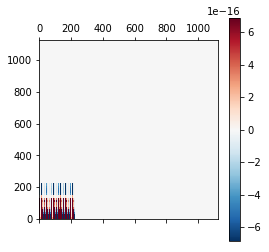

In [2240]:
plotter(c6mod)

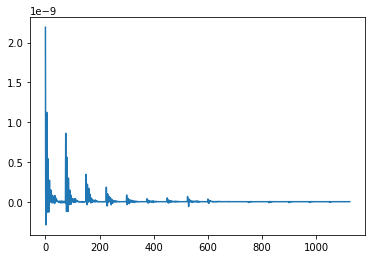

In [2241]:
plt.plot(np.diag(c60))

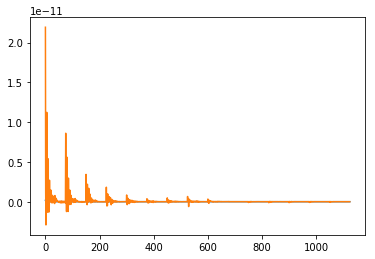

In [2242]:
plt.plot(np.diag(c6mod))
plt.plot(np.diag(c60)/100)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


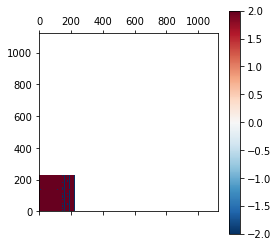

In [2243]:
plotter(rebinner(c60)/c6mod,vmax=2)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


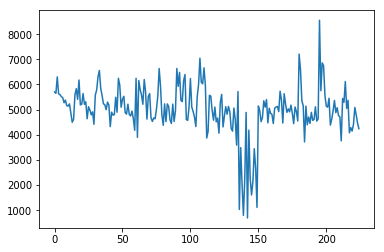

In [2244]:
plt.plot(rebinner(c60)[:,10]/c6mod[:,10])

In [2245]:
np.mean(np.diag(rebinner(c60)/c6mod))

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


nan

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


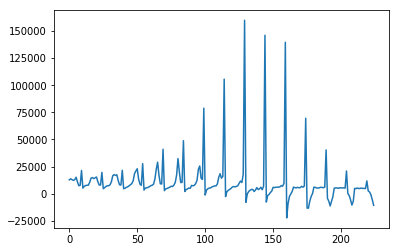

In [2246]:
plt.plot(np.diag(rebinner(c60)/c6mod))

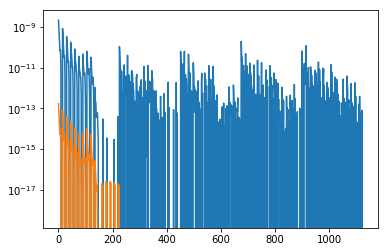

In [2247]:
plt.plot(np.diag(rebinner(c60)))
plt.plot(np.diag(c6mod))
plt.yscale('log');

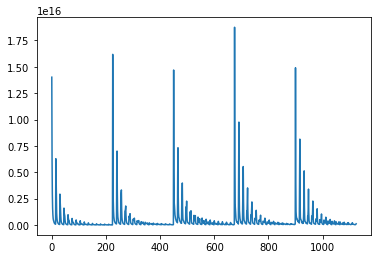

In [2248]:
c5mod = 3/(500**3*3e-4)*1e-20
plt.plot(np.diag(rebinner(c5))/c5mod)

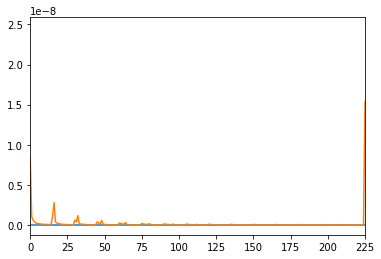

In [2249]:
plt.plot(np.diag(c4mod))
plt.plot(np.diag(c4test))
plt.xlim([0,225]);

(0.8, 1.2)

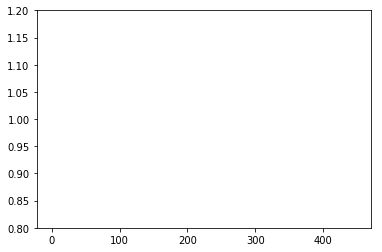

In [2250]:
ratio = []
for i in range(len(c4mod)):
    if c4test[i,i]>0:
        ratio.append(c4mod[i,i]/c4test[i,i])
plt.plot(ratio)
plt.ylim([0.8,1.2])

## Use SE compression

In [2251]:
good_r_bins=[]
for b1 in range(n):
    for b2 in range(n):
        r1=bins_r[b1,0]
        r2=bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            good_r_bins.append(b1)
good_r_bins = np.unique(np.asarray(good_r_bins))
n_g = len(good_r_bins)
min_r_bin = min(good_r_bins)

In [2252]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

In [2253]:
def compression(mat):
    comp_mat = np.zeros([n_g*m,n_g*m])
    den = np.zeros([n_g*m,n_g*m])

    all_v = 4.*np.pi*(bins_r[:,1]**3-bins_r[:,0]**3)/3

    for i in range(len(mat)):
        l = i%m
        b1 = (i//m)//n
        r1 = bins_r[b1,0]
        if b1<min_r_bin:
            continue
        b2 = (i//m)%n
        r2 = bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            v_b2 = all_v[b2]

            for j in range(len(mat)):
                l2 = j%m
                b3 = (j//m)//n
                r3 = bins_r[b3,0]
                if b3<min_r_bin:
                    continue
                b4 = (j//m)%n
                r4 = bins_r[b4,0]
                if (r4>=3*delta_r) and (r4<r3-3*delta_r):
                    v_b4 = all_v[b4]

                    comp_mat[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=mat[i,j]*v_b2*v_b4
                    den[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=v_b2*v_b4

    comp_mat/=den
    return comp_mat

In [2254]:
c3se=compression(c3s)
c4se=compression(c4s)
c5se=compression(c5s)
c6se=compression(c6s)
c_tot = c3se+c4se+c5se+c6se

In [2255]:
flat_r=bins_r[min_r_bin:].mean(axis=1)**2
all_r = np.concatenate([flat_r for i in range(len(c3se)//len(flat_r))])
r_mat = np.matmul(all_r.reshape(-1,1),all_r.reshape(1,-1))

In [2256]:
np.savez(indir+'../compressed_theory_cov.npz',c3=c3se,c4=c4se,
        c5=c5se,c6=c6se,c_tot=c_tot,r_mat=r_mat)

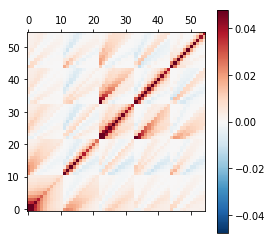

In [2257]:
plotter(c_tot*r_mat)

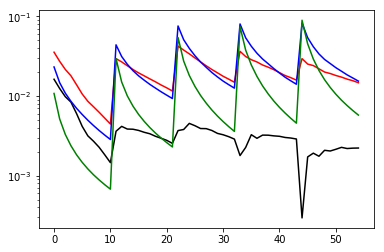

In [2258]:
f=1.#/10.
plt.plot(np.diag(c6se*r_mat),c='k')
plt.plot(np.diag(c5se*r_mat*f),c='r')
plt.plot(np.diag(c4se*r_mat*f**2),c='b')
plt.plot(np.diag(c3se*r_mat*f**3),c='g')
plt.yscale('log');

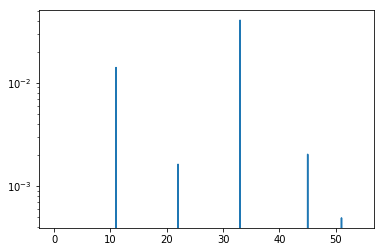

In [2259]:
plt.plot(np.diag((c6se-o6)*r_mat))
plt.plot(np.diag((c5se-o5)*r_mat))
plt.plot(np.diag((c4se-o4)*r_mat))
plt.plot(np.diag((c3se-o3)*r_mat))
plt.yscale('log')

In [2260]:
# o6=c6se
# o5=c5se
# o4=c4se
# o3=c3se

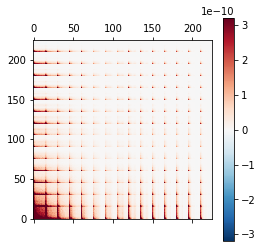

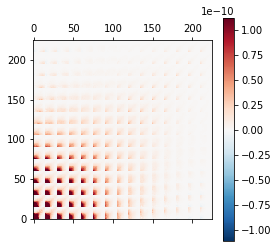

In [2217]:
plotter(rebinner(symmetrize(c60)))
plotter(rebinner(symmetrize(c61)))

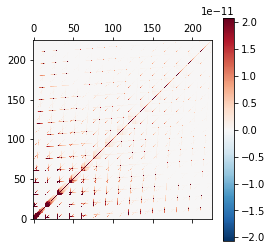

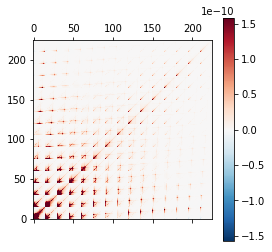

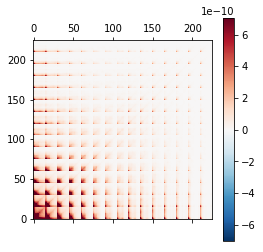

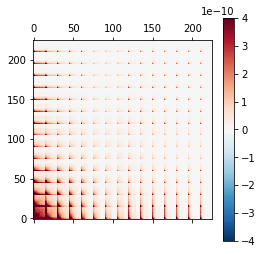

In [2218]:
plotter(rebinner(c3s))
plotter(rebinner(c4s))
plotter(rebinner(c5s))
plotter(rebinner(c6s))

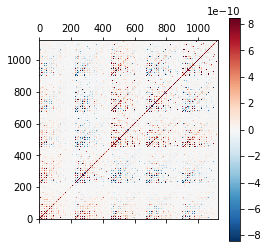

In [408]:
plotter(rebinner(c4s))

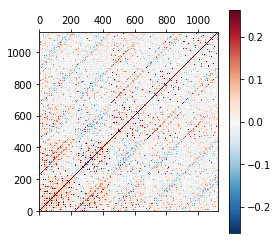

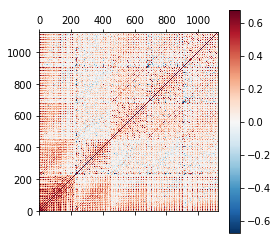

In [409]:
plotter(reduce(rebinner(c4s)))
plotter(reduce(rebinner(c5s)))

## Reduced Theory Covariance Matrix

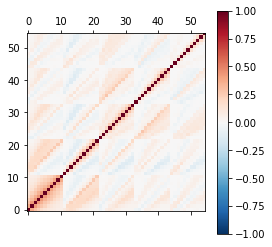

In [410]:
plotter(reduce(c6se+c5se+c4se+c3se))

## Full Theory Covariance Matrix

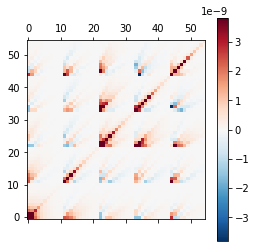

In [411]:
plotter(c6se+c5se+c4se+c3se)

**Difference between two C3 estimates**~

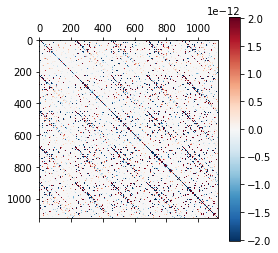

In [412]:
mat=rebinner(symmetrize(c30-c31))
vmax=np.percentile(rebinner(symmetrize(c30)),90.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [413]:
tot_mat = symmetrize(c3+c4+c5+c6)

## Total Matrix

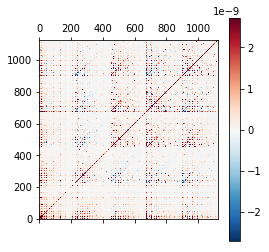

<Figure size 432x288 with 0 Axes>

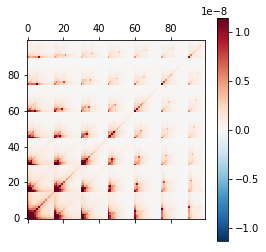

In [414]:
plotter(rebinner(symmetrize(tot_mat)))
plt.figure()
plotter(rebinner(symmetrize(tot_mat))[:100,:100])

In [415]:
b30=np.loadtxt(indir+'binct_c3_n%d_l%d_0_full.txt'%(n,l))
b40=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b50=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b60=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b31=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b41=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b51=np.loadtxt(indir+'binct_c5_n%d_l%d_0_full.txt'%(n,l))
b61=np.loadtxt(indir+'binct_c6_n%d_l%d_0_full.txt'%(n,l))

**6-point Sampling**

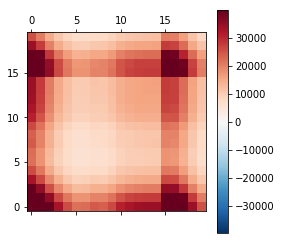

In [418]:
#plotter(rebinner(symmetrize(b60)))
plotter(rebinner(symmetrize(b61)),rmax=20)

**3 Point**

(0, 300)

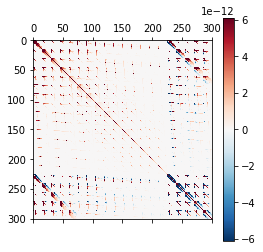

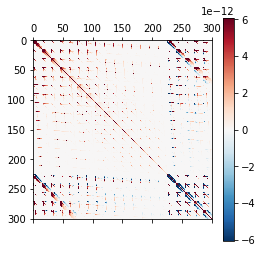

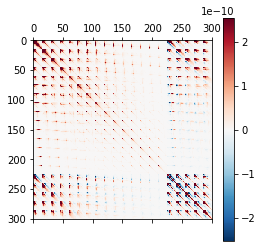

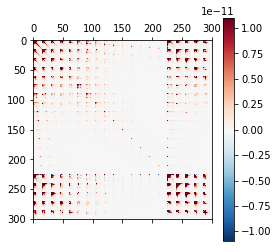

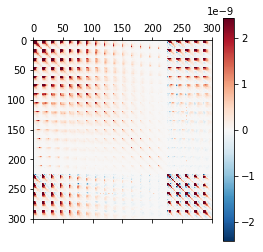

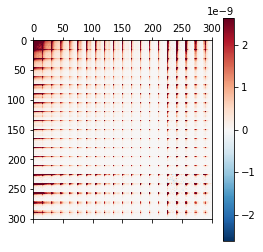

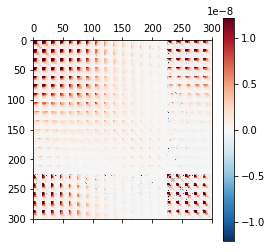

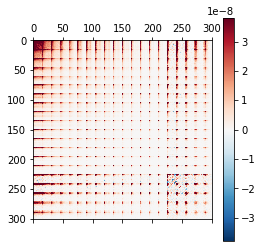

In [130]:
plotter(rebinner(symmetrize(c31)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c30)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c41)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c40)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c51)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c50)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c61)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c60)));plt.ylim([300,0]);plt.xlim([0,300])

In [56]:
def collapse_axes(mat,c_bin,d_bin):
    new_mat = np.zeros([m,m,n,n])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin,q_bin,a_bin,b_bin] = mat[i,c_bin*n+d_bin*m+q_bin]
    return new_mat

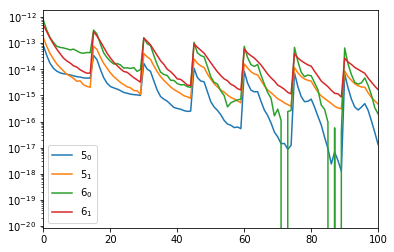

In [57]:
plt.plot(np.diag(rebinner(symmetrize(c50)))[:n*n],label=r'$5_0$')
plt.plot(np.diag(rebinner(symmetrize(c51)))[:n*n],label=r'$5_1$')
plt.plot(np.diag(rebinner(symmetrize(c60)))[:n*n],label=r'$6_0$')
plt.plot(np.diag(rebinner(symmetrize(c61)))[:n*n],label=r'$6_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

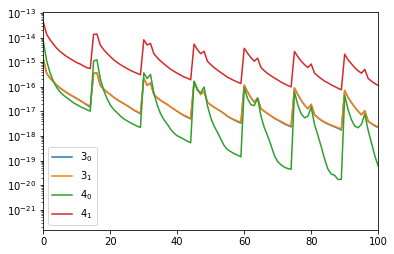

In [58]:
plt.plot(np.diag(rebinner(symmetrize(c30)))[:n*n],label=r'$3_0$')
plt.plot(np.diag(rebinner(symmetrize(c31)))[:n*n],label=r'$3_1$')
plt.plot(np.diag(rebinner(symmetrize(c40)))[:n*n],label=r'$4_0$')
plt.plot(np.diag(rebinner(symmetrize(c41)))[:n*n],label=r'$4_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

In [59]:
def variance(mat):
    out_mat = np.zeros([m,n,n])
    for p in range(m):
        for i in range(n):
            for j in range(n):
                out_mat[p,i,j]=mat[(i*n+j)*m+p,(i*n+j)*m+p]
    return out_mat

In [60]:
collapsed_mat = collapse_axes(tot_mat,5,7)
collapsed_mat.shape

(5, 5, 15, 15)

In [61]:
def collapse_axes_all_corr(mat,c_bin,d_bin):
    new_mat = np.zeros([n*m,n*m])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin*n+a_bin,q_bin*n+b_bin] += mat[i,c_bin*n*m+d_bin*m+q_bin]
    # Now compute correlation matrix
    corr_mat = np.zeros([n*m,n*m])
    for i in range(len(corr_mat)):
        p_bin = i//n
        a_bin = i%n
        for j in range(len(corr_mat[0])):
            q_bin = j//n
            b_bin = j%n
            corr_mat[p_bin*n+a_bin,q_bin*n+b_bin]=new_mat[p_bin*n+a_bin,q_bin*n+b_bin]/np.sqrt(new_mat[p_bin*n+a_bin,q_bin*n+a_bin]*new_mat[p_bin*n+b_bin,q_bin*n+b_bin])
    return corr_mat

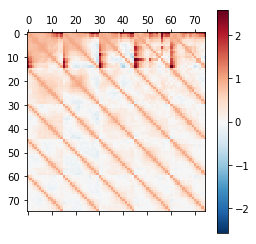

In [62]:
collapsed_mat = collapse_axes_all_corr(tot_mat,5,7)
vmax=np.percentile(collapsed_mat,99.9)
plt.matshow(collapsed_mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
#plt.title(r'$C_{%d%d}$'%(2*i,2*j))
plt.colorbar();

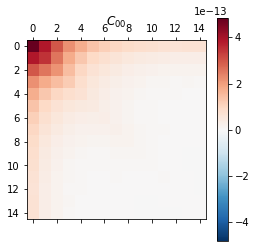

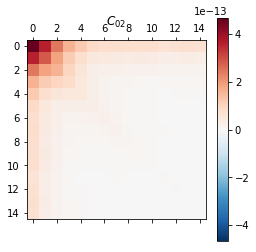

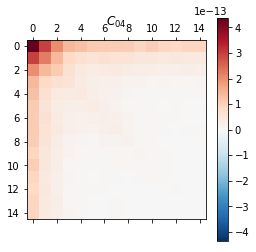

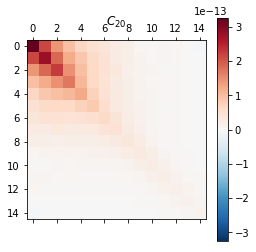

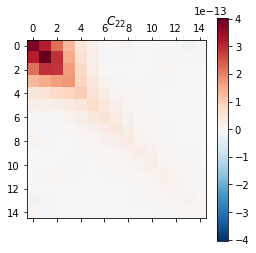

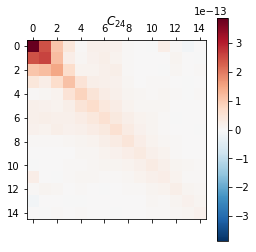

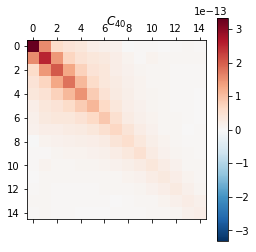

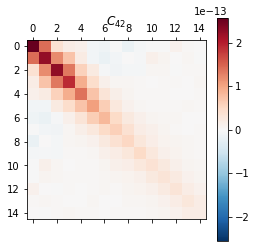

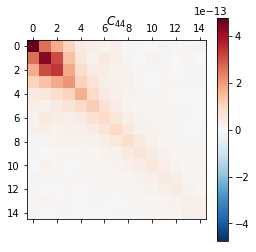

In [63]:
collapsed_mat = collapse_axes(tot_mat,5,2)
for i in range(3):
    for j in range(3):
        vmax=np.percentile(collapsed_mat[i,j],99.9)
        plt.matshow(collapsed_mat[i,j],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
        plt.title(r'$C_{%d%d}$'%(2*i,2*j))
        plt.colorbar();